# Avellaneda-Stoikov

In [2]:
import sys
sys.path.append("../") # my version of this notebook is in the subfolder "notebooks" of the repo

import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from copy import deepcopy

from stable_baselines3 import A2C, PPO, TD3
import stable_baselines3

from stochastic.processes.continuous import BrownianMotion, GeometricBrownianMotion, BesselProcess, BrownianBridge, BrownianMeander
from stochastic.processes.diffusion import ConstantElasticityVarianceProcess

from main.agents.Agent import Agent
from main.agents.AvellanedaStoikovAgent import AvellanedaStoikovAgent
from main.agents.BaselineAgents import RandomAgent, FixedSpreadAgent
from main.agents.SBAgent import SBAgent
from main.gym.ModelBasedEnvironment import ModelBasedEnvironment
from main.gym.models import *
from main.gym.AvellanedaStoikovEnvironment import AvellanedaStoikovEnvironment
from main.gym.helpers.generate_trajectory import generate_trajectory
from main.gym.helpers.plotting import *
from main.rewards.RewardFunctions import InventoryAdjustedPnL

## Random strategy

In [3]:
terminal_time = 1.0
n_steps = 200
timestamps = np.linspace(0, terminal_time, n_steps + 1)

as_env = AvellanedaStoikovEnvironment(terminal_time=terminal_time, n_steps=n_steps, seed=42)

In [4]:
random = RandomAgent(as_env.action_space,seed=42)

In [6]:
len(timestamps)

201

In [7]:
np.random.seed(42)
as_env = AvellanedaStoikovEnvironment(terminal_time=terminal_time, n_steps=n_steps, seed=42)

In [8]:
np.random.seed(42)
observations, actions, rewards = generate_trajectory(as_env,random)

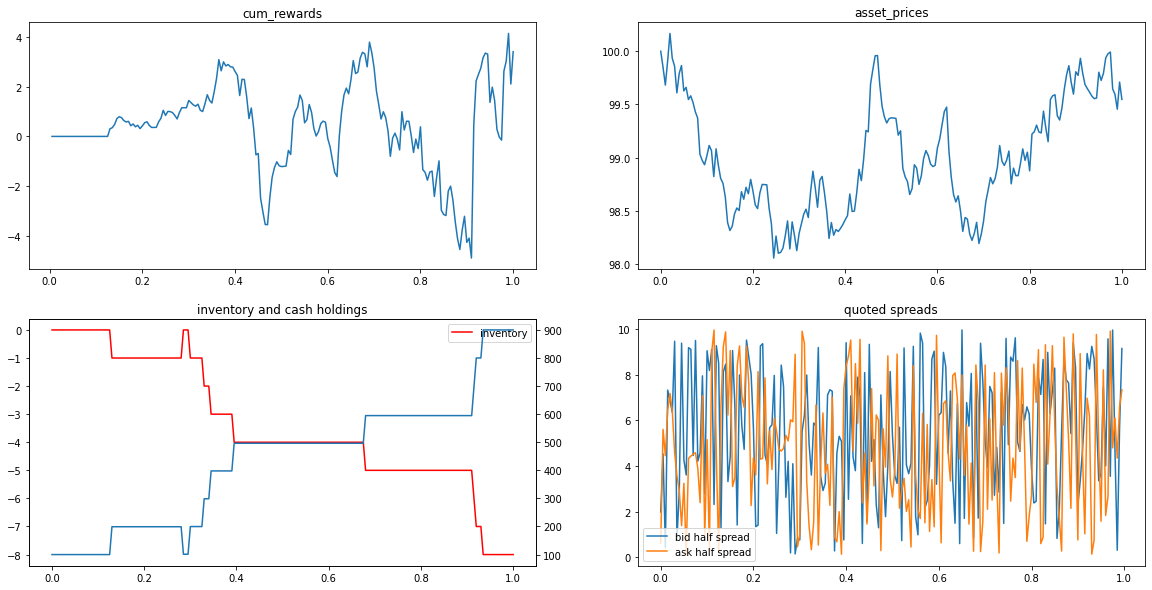

In [10]:
plot_as_trajectory(as_env, random, seed = 42)

## Fixed strategies

In [12]:
half_spreads = [0.25,0.5,1,2,4]

In [16]:
performance_dict = {}

for hs in half_spreads:
    np.random.seed(42)
    agent = FixedSpreadAgent(half_spread=hs)
    performance_dict[hs] = {}
    performance_dict[hs]["observations"], rewards, performance_dict[hs]["actions"]= generate_trajectory(as_env,agent)
    performance_dict[hs]["cum_rewards"] = np.cumsum(rewards)

ValueError: x and y must have same first dimension, but have shapes (201,) and (400,)

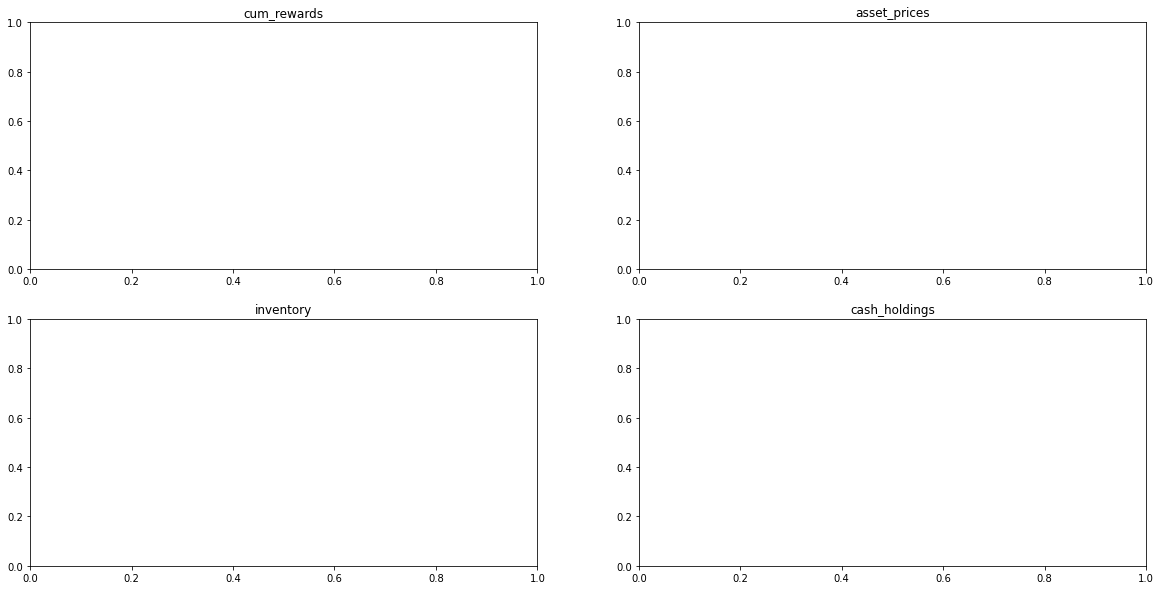

In [18]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize = (20,10))

ax1.title.set_text("cum_rewards")
ax2.title.set_text("asset_prices")
ax3.title.set_text("inventory")
ax4.title.set_text("cash_holdings")

for hs in half_spreads:
    ax1.plot(timestamps,performance_dict[hs]["cum_rewards"], label = hs)
    ax2.plot(timestamps,performance_dict[hs]["observations"][:,0], label = hs)
    ax3.plot(timestamps,performance_dict[hs]["observations"][:,2], label = hs)
    ax4.plot(timestamps,performance_dict[hs]["observations"][:,1], label = hs)
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
plt.show()             

## Avellaneda-Stoikov Optimal Strategy

In [14]:
N_STEPS = 200
as_agent = AvellanedaStoikovAgent(n_steps=N_STEPS)

In [16]:
observations, rewards, actions = generate_trajectory(as_env,as_agent)
cum_rewards = np.cumsum(rewards)
midprices=observations[:,0]
bid_half_spreads, ask_half_spreads = actions.T

ValueError: too many values to unpack (expected 2)

In [48]:
bid_prices = midprices - bid_half_spreads
ask_prices = midprices + ask_half_spreads

NameError: name 'midprices' is not defined

In [ ]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize = (20,10))

ax1.title.set_text("cum_rewards")
ax2.title.set_text("asset_prices")
ax3.title.set_text("inventory")
ax4.title.set_text("cash_holdings")

ax1.plot(cum_rewards)
ax2.plot(midprices, label="midprice")
ax2.plot(midprices-bid_half_spreads, label="quoted bid prices")
ax2.plot(midprices+ask_half_spreads, label="quoted ask prices")
ax3.plot(observations[:,2])
ax4.plot(observations[:,1])

ax2.legend()

plt.show()

### Comparing the results to the Avellaneda Stoikov paper

In [ ]:
results, fig, _ = generate_results_table_and_hist(agent=as_agent,env=env,n_episodes=1000, plot_symmetric=True)

In [ ]:
results

These results look similar to Table 2 of Avellaneda and Stoikov. It is interesting that the agent **does** quote a negative spread sometimes, which could be interpreted as taking liquidity but then the model should possibly be changed.

In [ ]:
fig

### Reproducing Table 3 and Figure 4

In [ ]:
as_agent = AvellanedaStoikovAgent(risk_aversion=1)

In [ ]:
results, fig, _ = generate_results_table_and_hist(agent=as_agent,env=as_env,n_episodes=1000, plot_symmetric=True)
results

In [ ]:
fig

## The effect of increasing risk aversion

In [ ]:
risk_aversions = [0.01,0.1,1,10]

In [ ]:
total_rewards_dict = dict()
for risk_aversion in risk_aversions:
    agent = AvellanedaStoikovAgent(risk_aversion=risk_aversion)
    _,_,total_rewards_dict[risk_aversion] = generate_results_table_and_hist(agent=agent,env=as_env,n_episodes=1000);   

In [ ]:
colors = ["r", "g", "b", "c"]

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
for risk_aversion, color in zip(risk_aversions,colors):
    sns.histplot(total_rewards_dict[risk_aversion], label=f"risk-aversion {risk_aversion}", stat = "density", bins = 50, ax=ax, color=color)
ax.legend()
plt.show()

**Note, it is hard to argue that the risk-averse agent is outperforming the non risk-averse agent in these cases...**

## Training a stable baselines agent on the Avellaneda-Stoikov gym environment

### Learning the risk neutral optimal behaviour

In [ ]:
as_env

In [ ]:
model = PPO('MlpPolicy', as_env, verbose=1, tensorboard_log="./tensorboard/PPO-learning-AS-pnl/")

In [ ]:
model.learn(total_timesteps=1000000);

In [ ]:
sb_agent = SBAgent(model=model)
observations, rewards, actions = generate_trajectory(env,sb_agent)
plot_as_trajectory(rewards,observations, timestamps)

In [ ]:
_,_,total_sb_rewards = generate_results_table_and_hist(env=env, agent=sb_agent,n_episodes=100);

In [ ]:
risk_neutral_agent = AvellanedaStoikovAgent(risk_aversion=0)
_,_,total_risk_neutral_rewards = generate_results_table_and_hist(agent=risk_neutral_agent,env=env,n_episodes=100);

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (20,10))
sns.histplot(total_sb_rewards, stat = "density", bins = 50, ax=ax, color="r", label="Stable baselines agent")
sns.histplot(total_risk_neutral_rewards, stat = "density", bins = 50, ax=ax, color="b", label = "Avellaneda-Stoikov risk-neutral agent")
plt.legend()
plt.show()

#### Investigating the learnt policy

In [ ]:
step_size = 1
timestamps = np.arange(as_env.observation_space.low[3],as_env.observation_space.high[3]+step_size,1)
inventory = 1
stock_price = 100
cash = 100

In [ ]:
inventory_action_dict = {}
for inventory in [-3,-2,-1,0,1,2,3]:
    actions = model.predict([stock_price,cash,inventory,0], deterministic=True)[0].reshape((1,2))
    for ts in timestamps[1:]:
        actions = np.append(actions, model.predict([stock_price,cash,inventory,ts],deterministic=True)[0].reshape((1,2)),axis=0)
    inventory_action_dict[inventory]=actions

In [ ]:
as_inventory_action_dict = {}
for inventory in [-3,-2,-1,0,1,2,3]:
    actions = as_agent.get_action([stock_price,cash,inventory,0]).reshape((1,2))
    for ts in timestamps[1:]:
        actions = np.append(actions, as_agent.get_action([stock_price,cash,inventory,ts]).reshape((1,2)),axis=0)
        as_inventory_action_dict[inventory]=actions

In [ ]:
# for inventory in [-3,-2,-1,0,1,2,3]:
#     plt.plot(np.array(inventory_action_dict[inventory]).T[0], label=str(inventory))
for inventory in [-3,-2,-1,0,1,2,3]:
    plt.plot(np.array(as_inventory_action_dict[inventory]).T[0], label="as "+str(inventory))
plt.legend()
plt.show()

In [ ]:
# for inventory in [-3,-2,-1,0,1,2,3]:
#     plt.plot(np.array(inventory_action_dict[inventory]).T[1], label=inventory)
for inventory in [-3,-2,-1,0,1,2,3]:
    plt.plot(np.array(as_inventory_action_dict[inventory]).T[1], label="as "+str(inventory))
plt.legend()
plt.show()

### Learning inventory-averse rewards

In [ ]:
per_step_inventory_aversion = 0.01

In [ ]:
risk_averse_env = AvellanedaStoikovEnvironment(reward_function=InventoryAdjustedPnL(inventory_aversion_exponent=3/2))

In [ ]:
model = PPO('MlpPolicy', risk_averse_env, verbose=1, tensorboard_log="./tensorboard/PPO-learning-AS-per-step-inventory-averse/")

In [ ]:
model.learn(total_timesteps=300000);

In [ ]:
sb_agent = SBAgent(model=model)
observations, rewards, actions = generate_trajectory(risk_averse_env,sb_agent)
plot_as_trajectory(rewards,observations)

In [ ]:
risk_averse_agent = AvellanedaStoikovAgent(risk_aversion=0)
_,_,total_risk_averse_rewards = generate_results_table_and_hist(agent=risk_averse_agent,env=env,n_episodes=1000);

In [ ]:
_,_,total_sb_rewards = generate_results_table_and_hist(env=env, agent=sb_agent,n_episodes=1000);

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (20,10))
sns.histplot(total_sb_rewards, stat = "density", bins = 50, ax=ax, color="r", label="Stable baselines agent")
sns.histplot(total_risk_averse_rewards, stat = "density", bins = 50, ax=ax, color="b", label = "Avellaneda-Stoikov risk-neutral agent")
plt.legend()
plt.show()

In [ ]:
state = env.reset()

In [ ]:
bid_spreads = [model.predict(state)[0][0] for _ in range(1000)]

In [ ]:
plt.hist(bid_spreads, bins=20)